# 07 - Meta-Learners
 


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from fklearn.causal.validation.curves import relative_cumulative_gain_curve
from fklearn.causal.validation.auc import area_under_the_relative_cumulative_gain_curve


from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

## Meta-Learners for Discrete Treatments

In [2]:
pd.set_option('display.max_columns', 10)

In [3]:
import pandas as pd
import numpy as np

data_biased = pd.read_csv("./data/email_obs_data.csv")
data_rnd = pd.read_csv("./data/email_rnd_data.csv")

print(len(data_biased), len(data_rnd))
data_rnd.head()

300000 10000


,mkt_email,next_mnth_pv,age,tenure,ammount_spent,...,pc,jewel,books,music_books_movies,health
0,0,244.26,61.0,1.0,21.84,...,0,1,0,0,2
1,0,29.67,36.0,1.0,107.40,...,2,1,0,2,2
2,0,11.73,64.0,0.0,59.81,...,1,0,1,0,1
3,0,41.41,74.0,0.0,62.98,...,1,0,4,1,0
4,0,447.89,59.0,0.0,72.56,...,0,1,1,2,1


In [4]:
y = "next_mnth_pv"
T = "mkt_email"
X = list(data_rnd.drop(columns=[y, T]).columns)

train, test = data_biased, data_rnd

### T-Learner


In [5]:
from lightgbm import LGBMRegressor

np.random.seed(123)

m0 = LGBMRegressor()
m1 = LGBMRegressor()

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y]);

In [6]:
t_learner_cate_test = test.assign(
    cate=m1.predict(test[X]) - m0.predict(test[X])
)

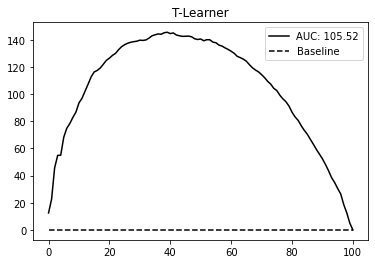

In [7]:
gain_curve_test = relative_cumulative_gain_curve(t_learner_cate_test, T, y, prediction="cate")
auc = area_under_the_relative_cumulative_gain_curve(t_learner_cate_test, T, y, prediction="cate")

plt.plot(gain_curve_test, color="C0", label=f"AUC: {auc:.2f}")
plt.hlines(0, 0, 100, linestyle="--", color="black", label="Baseline")

plt.legend();
plt.title("T-Learner");

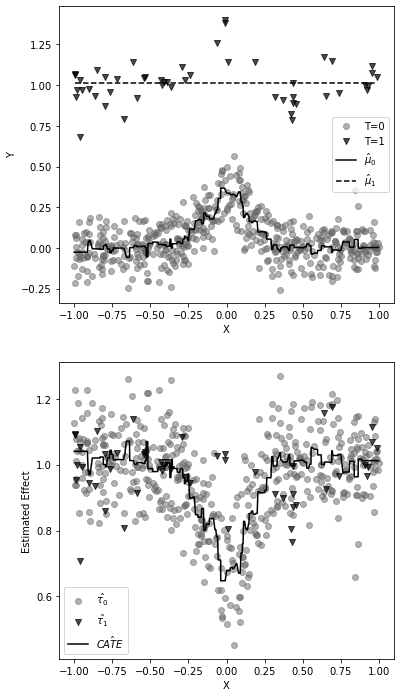

In [10]:
np.random.seed(123)

def g_kernel(x, c=0, s=0.05): 
    return np.exp((-(x-c)**2)/s)

n0 = 500
x0 = np.random.uniform(-1, 1, n0)
y0 = np.random.normal(0.3*g_kernel(x0), 0.1, n0)

n1 = 50
x1 = np.random.uniform(-1, 1, n1)
y1 = np.random.normal(0.3*g_kernel(x1), 0.1, n1)+1

df = pd.concat([pd.DataFrame(dict(x=x0, y=y0, t=0)), pd.DataFrame(dict(x=x1, y=y1, t=1))]).sort_values(by="x")

m0 = LGBMRegressor(min_child_samples=25)
m1 = LGBMRegressor(min_child_samples=25)

m0.fit(x0.reshape(-1, 1), y0)
m1.fit(x1.reshape(-1, 1), y1)

m0_hat = m0.predict(df.query("t==0")[["x"]])
m1_hat = m1.predict(df.query("t==1")[["x"]])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.scatter(x0, y0, alpha=0.5, label="T=0", marker=marker[0], color=color[1])
ax1.scatter(x1, y1, alpha=0.7, label="T=1", marker=marker[1], color=color[0])

ax1.plot(df.query("t==0")[["x"]], m0_hat, color="black", linestyle="solid",  label="$\hat{\mu}_0$")
ax1.plot(df.query("t==1")[["x"]], m1_hat, color="black", linestyle="--",  label="$\hat{\mu}_1$")

ax1.set_ylabel("Y")
ax1.set_xlabel("X")
ax1.legend();

tau_0 = m1.predict(df.query("t==0")[["x"]]) - df.query("t==0")["y"]
tau_1 = df.query("t==1")["y"] - m0.predict(df.query("t==1")[["x"]])

ax2.scatter(df.query("t==0")[["x"]], tau_0, label="$\hat{\\tau_0}$", alpha=0.5, marker=marker[0], color=color[1])
ax2.scatter(df.query("t==1")[["x"]], tau_1, label="$\hat{\\tau_1}$", alpha=0.7, marker=marker[1], color=color[0])

ax2.plot(df[["x"]], m1.predict(df[["x"]]) - m0.predict(df[["x"]]), label="$\hat{CATE}$",  color="black")

ax2.set_ylabel("Estimated Effect")
ax2.set_xlabel("X")
ax2.legend();

### X-Learner


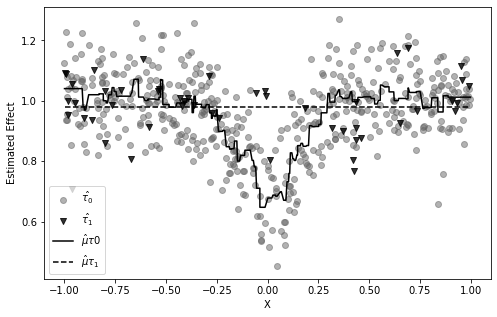

In [9]:
from sklearn.linear_model import LogisticRegression

np.random.seed(1)

mu_tau0 = LGBMRegressor(min_child_samples=25)
mu_tau1 = LGBMRegressor(min_child_samples=25)

mu_tau0.fit(df.query("t==0")[["x"]], tau_0)
mu_tau1.fit(df.query("t==1")[["x"]], tau_1)

mu_tau0_hat = mu_tau0.predict(df.query("t==0")[["x"]])
mu_tau1_hat = mu_tau1.predict(df.query("t==1")[["x"]])

plt.figure(figsize=(8, 5))
plt.scatter(df.query("t==0")[["x"]], tau_0, label="$\hat{\\tau_0}$", alpha=0.5, marker=marker[0], color=color[1])
plt.scatter(df.query("t==1")[["x"]], tau_1, label="$\hat{\\tau_1}$", alpha=0.8, marker=marker[1], color=color[0])
plt.plot(df.query("t==0")[["x"]], mu_tau0_hat, color="black", linestyle="solid", label="$\hat{\mu}\\tau 0$")
plt.plot(df.query("t==1")[["x"]], mu_tau1_hat, color="black", linestyle="dashed", label="$\hat{\mu}\\tau_1$")
plt.ylabel("Estimated Effect")
plt.xlabel("X")
plt.legend();

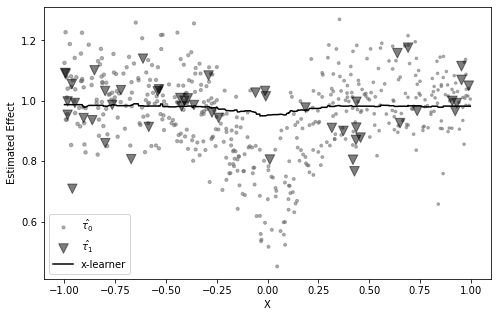

In [10]:
plt.figure(figsize=(8, 5))

ps_model = LogisticRegression(penalty="none")
ps_model.fit(df[["x"]], df["t"])

ps = ps_model.predict_proba(df[["x"]])[:, 1]

cate = ((1-ps)*mu_tau1.predict(df[["x"]]) +
        ps*mu_tau0.predict(df[["x"]]))

plt.scatter(df.query("t==0")[["x"]], tau_0, label="$\hat{\\tau_0}$", alpha=0.5, s=100*(ps[df["t"]==0]),   marker=marker[0], color=color[1])
plt.scatter(df.query("t==1")[["x"]], tau_1, label="$\hat{\\tau_1}$", alpha=0.5, s=100*(1-ps[df["t"]==1]), marker=marker[1], color=color[0])

plt.plot(df[["x"]], cate, label="x-learner", color="black")
plt.ylabel("Estimated Effect")
plt.xlabel("X")
plt.legend();

In [11]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor

# propensity score model
ps_model = LogisticRegression(penalty='none')
ps_model.fit(train[X], train[T])


# first stage models
train_t0 = train.query(f"{T}==0")
train_t1 = train.query(f"{T}==1")

m0 = LGBMRegressor()
m1 = LGBMRegressor()

np.random.seed(123)

m0.fit(train_t0[X], train_t0[y],
       sample_weight=1/ps_model.predict_proba(train_t0[X])[:, 0])

m1.fit(train_t1[X], train_t1[y],
       sample_weight=1/ps_model.predict_proba(train_t1[X])[:, 1]);


In [12]:
# second stage
tau_hat_0 = m1.predict(train_t0[X]) - train_t0[y]
tau_hat_1 = train_t1[y] - m0.predict(train_t1[X])

m_tau_0 = LGBMRegressor()
m_tau_1 = LGBMRegressor()

np.random.seed(123)

m_tau_0.fit(train_t0[X], tau_hat_0)
m_tau_1.fit(train_t1[X], tau_hat_1);

In [13]:
# estimate the CATE
ps_test = ps_model.predict_proba(test[X])[:, 1]

x_cate_test = test.assign(
    cate=(ps_test*m_tau_0.predict(test[X]) +
          (1-ps_test)*m_tau_1.predict(test[X])
         )
)

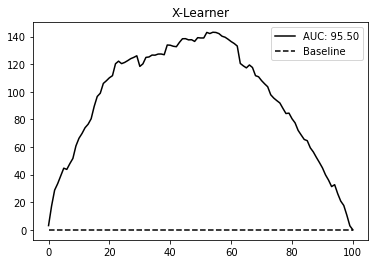

In [14]:
gain_curve_test = relative_cumulative_gain_curve(x_cate_test, T, y, prediction="cate")
auc = area_under_the_relative_cumulative_gain_curve(x_cate_test, T, y, prediction="cate")

plt.plot(gain_curve_test, color="C0", label=f"AUC: {auc:.2f}")
plt.hlines(0, 0, 100, linestyle="--", color="black", label="Baseline")

plt.legend();
plt.title("X-Learner");

## Meta-Learners for Continuous Treatments


In [15]:
data_cont = pd.read_csv("./data/discount_data.csv")
data_cont.head()

,rest_id,day,month,weeday,weekend,...,is_dec,is_nov,competitors_price,discounts,sales
0,0,2016-01-01,1,4,False,...,False,False,2.88,0,79.0
1,0,2016-01-02,1,5,True,...,False,False,2.64,0,57.0
2,0,2016-01-03,1,6,True,...,False,False,2.08,5,294.0
3,0,2016-01-04,1,0,False,...,False,False,3.37,15,676.5
4,0,2016-01-05,1,1,False,...,False,False,3.79,0,66.0


In [16]:
train = data_cont.query("day<'2018-01-01'")
test = data_cont.query("day>='2018-01-01'")

### S-Learner


In [17]:
X = ["month", "weeday", "is_holiday", "competitors_price"]
T = "discounts"
y = "sales"

np.random.seed(123)
s_learner = LGBMRegressor()
s_learner.fit(train[X+[T]], train[y]);

In [18]:
t_grid = pd.DataFrame(dict(key=1,
                           discounts=np.array([0, 10, 20, 30, 40])))

test_cf = (test
           .drop(columns=["discounts"])
           .assign(key=1)
           .merge(t_grid)
           # make predictions after expansion
           .assign(sales_hat = lambda d: s_learner.predict(d[X+[T]])))

test_cf.head(8)

,rest_id,day,month,weeday,weekend,...,competitors_price,sales,key,discounts,sales_hat
0,0,2018-01-01,1,0,False,...,4.92,251.5,1,0,67.957972
1,0,2018-01-01,1,0,False,...,4.92,251.5,1,10,444.245941
2,0,2018-01-01,1,0,False,...,4.92,251.5,1,20,793.045769
3,0,2018-01-01,1,0,False,...,4.92,251.5,1,30,1279.640793
4,0,2018-01-01,1,0,False,...,4.92,251.5,1,40,1512.630767
5,0,2018-01-02,1,1,False,...,3.06,541.0,1,0,65.672080
6,0,2018-01-02,1,1,False,...,3.06,541.0,1,10,495.669220
7,0,2018-01-02,1,1,False,...,3.06,541.0,1,20,1015.401471


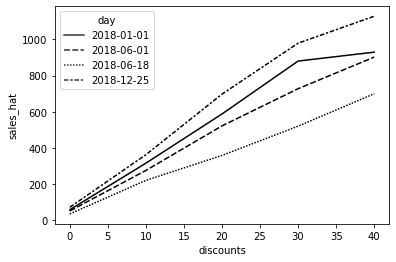

In [19]:
days = ["2018-12-25", "2018-01-01", "2018-06-01", "2018-06-18"]
sns.lineplot(data=test_cf.query("day.isin(@days)").query("rest_id==2"),
             palette="gray",
             y="sales_hat",
             x="discounts",
             style="day");

In [20]:
from toolz import curry

@curry
def linear_effect(df, y, t):
    return np.cov(df[y], df[t])[0, 1]/df[t].var()


cate = (test_cf
        .groupby(["rest_id", "day"])
        .apply(linear_effect(t="discounts", y="sales_hat"))
        .rename("cate"))

test_s_learner_pred = test.set_index(["rest_id", "day"]).join(cate)

test_s_learner_pred.head()

month  weeday  weekend  is_holiday  is_dec  is_nov  \
rest_id day                                                              
0       2018-01-01      1       0    False        True   False   False   
        2018-01-02      1       1    False       False   False   False   
        2018-01-03      1       2    False       False   False   False   
        2018-01-04      1       3    False       False   False   False   
        2018-01-05      1       4    False       False   False   False   

                    competitors_price  discounts  sales       cate  
rest_id day                                                         
0       2018-01-01               4.92          5  251.5  37.247404  
        2018-01-02               3.06         10  541.0  40.269854  
        2018-01-03               4.61         10  431.0  37.412988  
        2018-01-04               4.84         20  760.0  38.436815  
        2018-01-05               6.29          0   78.0  31.428603

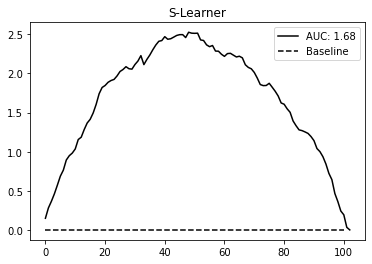

In [21]:
from fklearn.causal.validation.auc import area_under_the_relative_cumulative_gain_curve
from fklearn.causal.validation.curves import relative_cumulative_gain_curve

gain_curve_test = relative_cumulative_gain_curve(test_s_learner_pred, T, y, prediction="cate")
auc = area_under_the_relative_cumulative_gain_curve(test_s_learner_pred, T, y, prediction="cate")

plt.plot(gain_curve_test, color="C0", label=f"AUC: {auc:.2f}")
plt.hlines(0, 0, 100, linestyle="--", color="black", label="Baseline")

plt.legend();
plt.title("S-Learner");

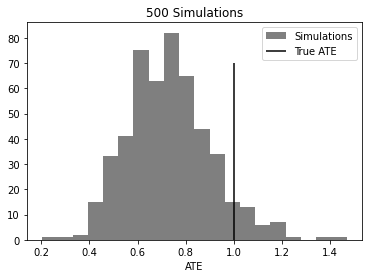

In [22]:
np.random.seed(123)

def sim_s_learner_ate():
    n = 10000
    nx = 20
    
    X = np.random.normal(0, 1, (n, nx))
    coefs_y = np.random.uniform(-1, 1, nx)
    coefs_t = np.random.uniform(-0.5, 0.5, nx)
    
    ps = 1/(1+np.exp(-(X.dot(coefs_t))))
    t = np.random.binomial(1, ps)
    te = 1
    
    y = np.random.normal(t*te + X.dot(coefs_y), 1)
    
    s_learner = LGBMRegressor(max_depth=5, n_jobs=4)
    s_learner.fit(np.concatenate([X, t.reshape(-1, 1)], axis=1), y);
    
    ate_hat = (s_learner.predict(np.concatenate([X, np.ones((n, 1))], axis=1))
               - s_learner.predict(np.concatenate([X, np.zeros((n, 1))], axis=1))).mean()
    
    return ate_hat
    
    
ates = [sim_s_learner_ate() for _ in range(500)]

plt.hist(ates, alpha=0.5, bins=20, label="Simulations")
plt.vlines(1, 0, 70, label="True ATE")
plt.legend()
plt.xlabel("ATE")
plt.title("500 Simulations");

### Double/Debiased Machine Learning


In [23]:
from sklearn.model_selection import cross_val_predict

X = ["month", "weeday", "is_holiday", "competitors_price"]
T = "discounts"
y = "sales"

debias_m = LGBMRegressor()
denoise_m = LGBMRegressor()

t_res =  train[T] - cross_val_predict(debias_m, train[X], train[T], cv=5)
y_res =  train[y] - cross_val_predict(denoise_m, train[X], train[y], cv=5)

In [24]:
import statsmodels.api as sm

sm.OLS(y_res, t_res).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
discounts,31.4615,0.151,208.990,0.000,31.166,31.757


#### Double-ML for CATE Estimation


In [25]:
y_star = y_res/t_res
w = t_res**2

cate_model = LGBMRegressor().fit(train[X], y_star, sample_weight=w)

test_r_learner_pred = test.assign(cate = cate_model.predict(test[X]))

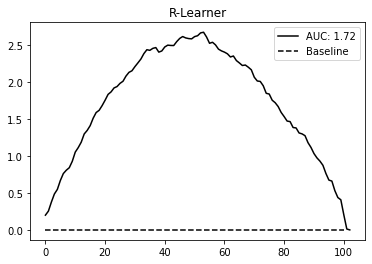

In [26]:
gain_curve_test = relative_cumulative_gain_curve(test_r_learner_pred, T, y, prediction="cate")
auc = area_under_the_relative_cumulative_gain_curve(test_r_learner_pred, T, y, prediction="cate")

plt.plot(gain_curve_test, color="C0", label=f"AUC: {auc:.2f}")
plt.hlines(0, 0, 100, linestyle="--", color="black", label="Baseline")

plt.legend();
plt.title("R-Learner");

#### Visual Intuition for Double-ML


In [27]:
np.random.seed(123)
n = 5000

x_h = np.random.randint(1, 4, n)
x_c = np.random.uniform(-1, 1, n)

t = np.random.normal(10 + 1*x_c + 3*x_c**2 + x_c**3, 0.3)
y = np.random.normal(t + x_h*t - 5*x_c - x_c**2 - x_c**3, 0.3)

df_sim = pd.DataFrame(dict(x_h=x_h, x_c=x_c, t=t, y=y))

<AxesSubplot:xlabel='t', ylabel='y'>

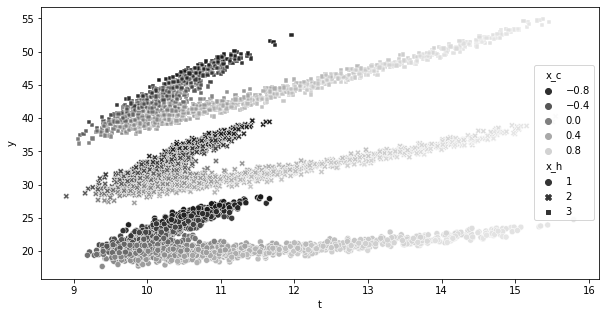

In [28]:
import matplotlib

plt.figure(figsize=(10, 5))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["0.1","0.5","0.9"])

sns.scatterplot(data=df_sim, y="y", x="t", hue="x_c", style="x_h", palette=cmap);

In [29]:
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

t_res = cross_val_predict(debias_m, df_sim[["x_c"]], df_sim["t"], cv=10)
y_res = cross_val_predict(denoise_m, df_sim[["x_c", "x_h"]], df_sim["y"], cv=10)

df_res = df_sim.assign(
    t_res =  df_sim["t"] - t_res,
    y_res =  df_sim["y"] - y_res
)

In [30]:
import statsmodels.formula.api as smf

smf.ols("y_res~t_res", data=df_res).fit().params["t_res"]

3.045230146006292

<AxesSubplot:xlabel='t_res', ylabel='y_res'>

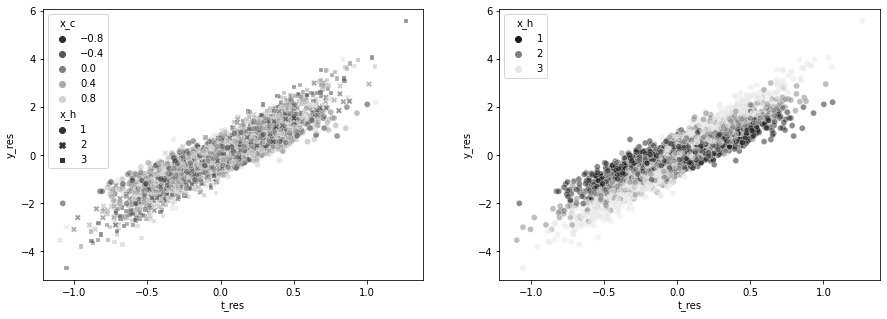

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(data=df_res, y="y_res", x="t_res", hue="x_c", style="x_h", alpha=0.5, ax=ax1, palette=cmap)
sns.scatterplot(data=df_res, y="y_res", x="t_res", hue="x_h", ax=ax2, alpha=0.5, palette=cmap);

In [32]:
df_star = df_res.assign(
    y_star = df_res["y_res"]/df_res["t_res"],
    weight = df_res["t_res"]**2,
)

for x in range(1, 4):
    cate = np.average(df_star.query(f"x_h=={x}")["y_star"],
                      weights=df_star.query(f"x_h=={x}")["weight"])
    
    print(f"CATE x_h={x}", cate)

CATE x_h=1 2.019759619990067
CATE x_h=2 2.974967932350952
CATE x_h=3 3.9962382855476957


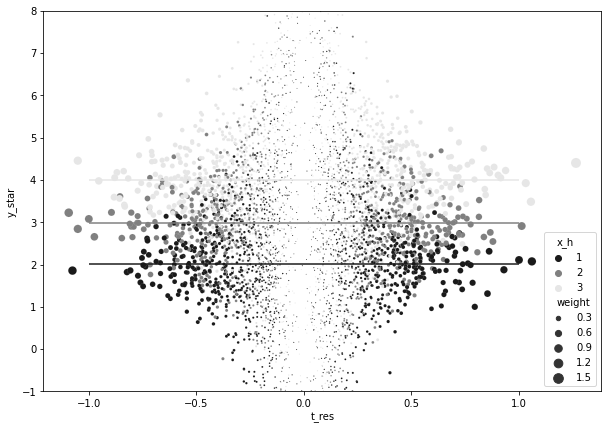

In [33]:
plt.figure(figsize=(10, 7))

sns.scatterplot(data=df_star, palette=cmap,
                y="y_star", x="t_res", hue="x_h", size="weight", sizes=(1, 100)), 

plt.hlines(np.average(df_star.query("x_h==1")["y_star"], weights=df_star.query("x_h==1")["weight"]),
           -1, 1, label="x_h=1", color="0.1")

plt.hlines(np.average(df_star.query("x_h==2")["y_star"], weights=df_star.query("x_h==2")["weight"]),
           -1, 1, label="x_h=2", color="0.5")

plt.hlines(np.average(df_star.query("x_h==3")["y_star"], weights=df_star.query("x_h==3")["weight"]),
           -1, 1, label="x_h=3", color="0.9")

plt.ylim(-1, 8);

## Key Ideas
